# Bayesian neural networks




In [1]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '7'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [7]


In [2]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)  # Do we need this here? -> it seems we do for the LML computations (otherwise NaNs get introduced), but not for performance

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import blackjax

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from distrax._src.distributions.distribution import Distribution

import os
import sys

import flax
from flax import linen as nn

from blackjax import normal_random_walk

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../../')))

import bamojax
from bamojax.base import Node, Model
from bamojax.sampling import gibbs_sampler, run_chain, smc_inference_loop

print('Python version:       ', sys.version)
print('Jax version:          ', jax.__version__)
print('BlackJax version:     ', blackjax.__version__)
print('Flax version:         ', flax.__version__)
print('Distrax version:      ', dx.__version__)
print('BaMoJax version:      ', bamojax.__version__)
print('Jax default backend:  ', jax.default_backend())
print('Jax devices:          ', jax.devices())

Python version:        3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:           0.4.35
BlackJax version:      1.2.4
Flax version:          0.10.0
Distrax version:       0.1.5
BaMoJax version:       0.0.1
Jax default backend:   gpu
Jax devices:           [CudaDevice(id=0)]


Code works for:

- Python version:        3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
- Jax version:           0.4.35
- BlackJax version:      1.2.4
- Flax version:          0.10.0
- Distrax version:       0.1.5
- BaMoJax version:       0.0.1

In [3]:
num_mcmc_steps = 50
num_particles = 1_000

## The basic MLP


In [4]:
class MLP(nn.Module):

    layer_widths: list[int]

    @nn.compact
    def __call__(self, x):
        for width in self.layer_widths:
            x = nn.Dense(features=width)(x)
            x = nn.tanh(x)
        return nn.Dense(features=1)(x)
    
    #    

#

Simulate observations:

In [5]:
from sklearn.datasets import make_moons

noise = 0.2
num_obs = 200

X, Y = make_moons(noise=noise, n_samples=num_obs)
n, p = X.shape

widths = [50, 40, 40]
network = MLP(layer_widths=widths)

def get_num_weights(widths, p):
    sizes = widths.copy()
    sizes.insert(0, p)
    sizes.append(1)

    m = 0
    for w in range(len(sizes) - 1):
        m += (sizes[w]+1) * sizes[w+1]
    return m

#
_, mlp_unravel_fn = jax.flatten_util.ravel_pytree(network.init(jrnd.PRNGKey(0), jnp.ones(p)))

num_weights = get_num_weights(widths, p)
print('Total number of weights in MLP:', num_weights)

Total number of weights in MLP: 3871


Why does this yield memory issues, whereas the previous implementation did not? And why does it only on occassion do this? Restarting the Jupyter kernel seems to help a bit.

Answer: previous approach used 50 mutation steps instead of 100!

In [6]:
def mlp_link_fn(w, x):  
    if jnp.ndim(x) == 1:
        x = x[:, None]

    w_ = mlp_unravel_fn(w)
    fpreds = network.apply(w_, x).squeeze()
    return dict(probs=jax.nn.sigmoid(fpreds))
    
#

In [7]:
%%time

key = jrnd.PRNGKey(42)
key, subkey = jrnd.split(key)
BNN = Model('Bayesian neural network')
weights = BNN.add_node('w', distribution=dx.Normal, parents=dict(loc=0.0, scale=0.5), shape=(num_weights,))
x_node = BNN.add_node('X', observations=X)
y_node = BNN.add_node('Y', distribution=dx.Bernoulli, parents=dict(w=weights, x=x_node), link_fn=mlp_link_fn, observations=Y)

step_fns = dict(w=normal_random_walk)
step_fn_params = dict(w=dict(sigma=0.01*jnp.eye(num_weights)))

gibbs = gibbs_sampler(BNN, step_fns=step_fns, step_fn_params=step_fn_params)
final_state, lml, n_iter, final_info = smc_inference_loop(subkey, model=BNN, kernel=gibbs, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

results_gaussian = (final_state, lml)

print(f'Acceptance rate w:', jnp.mean(final_info.update_info['w'].is_accepted))

del final_info
del final_state

Acceptance rate w: 0.4587
CPU times: user 1min 50s, sys: 6.9 s, total: 1min 57s
Wall time: 1min 57s


Visualize result

In [8]:
def plot_double_moon_fit(xgrid, logit, levels=20):
    xv, yv = xgrid
    data_colors = ["tab:red" if yn==1 else "tab:blue" for yn in Y]    
    _, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, constrained_layout=True, figsize=(8, 4))
    
    mu = jnp.mean(logit, axis=0)
    sigma = jnp.std(logit, axis=0)
    axes[0].contourf(xv, yv, mu, zorder=0, cmap="twilight", vmin=0.0, vmax=1.0, levels=levels)
    axes[1].contourf(xv, yv, sigma, zorder=0, cmap="inferno_r", vmin=0.0, vmax=0.4, levels=levels)

    axes[0].set_title('Expectation')
    axes[1].set_title('Uncertainty')

    for ax in axes.flatten():
        ax.scatter(*X.T, c=data_colors, zorder=2, linewidths=0.5, edgecolors='k')
        ax.set_xticks([])
        ax.set_yticks([])

#
def mlp_pred_fn(w, x):  
    if jnp.ndim(x) == 1:
        x = x[:, None]

    w_ = mlp_unravel_fn(w)
    fpreds = network.apply(w_, x).squeeze()
    ppreds = jax.nn.sigmoid(fpreds)
    return ppreds
    
#

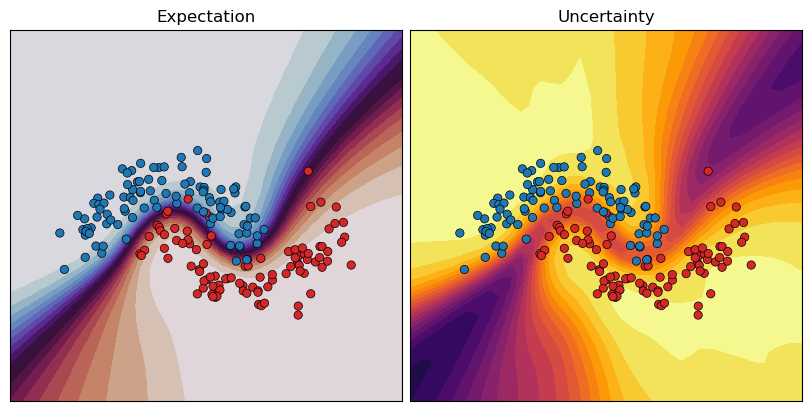

In [9]:
num_x, num_y = 40, 40
xv, yv = jnp.meshgrid(jnp.linspace(-2.0, 3.0, num=num_x), jnp.linspace(-2.0, 3.0, num=num_y))
xpred = jnp.vstack([xv.flatten(), yv.flatten()]).T

p_pred = jax.vmap(mlp_pred_fn, in_axes=(0, None))(results_gaussian[0].particles['w'], xpred)

plot_double_moon_fit((xv, yv), p_pred.reshape((num_particles, num_x, num_y)))

The shapes of the expectation and the uncertainty nicely follow the data distributions. 

In [10]:
print('log marginal likelihood:', results_gaussian[1])

log marginal likelihood: -42.54236104957


In [11]:
%%time

key = jrnd.PRNGKey(1337)
key, subkey = jrnd.split(key)
BNN_Laplace = Model('Bayesian neural network - Laplace prior')
weights = BNN_Laplace.add_node('w', distribution=dx.Laplace, parents=dict(loc=0.0, scale=0.5), shape=(num_weights,))
x_node = BNN_Laplace.add_node('X', observations=X)
y_node = BNN_Laplace.add_node('Y', distribution=dx.Bernoulli, parents=dict(w=weights, x=x_node), link_fn=mlp_link_fn, observations=Y)

step_fns = dict(w=normal_random_walk)
step_fn_params = dict(w=dict(sigma=0.01*jnp.eye(num_weights)))

gibbs = gibbs_sampler(BNN_Laplace, step_fns=step_fns, step_fn_params=step_fn_params)
final_state, lml, n_iter, final_info = smc_inference_loop(subkey, model=BNN_Laplace, kernel=gibbs, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

results_laplace = (final_state, lml)

print(f'Acceptance rate w:', jnp.mean(final_info.update_info['w'].is_accepted))

del final_info
del final_state

Acceptance rate w: 0.43943998
CPU times: user 1min 48s, sys: 6.51 s, total: 1min 54s
Wall time: 1min 58s


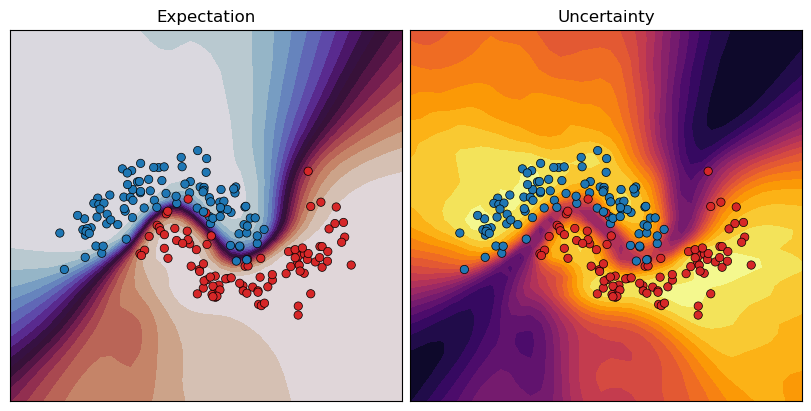

In [12]:
num_x, num_y = 40, 40
xv, yv = jnp.meshgrid(jnp.linspace(-2.0, 3.0, num=num_x), jnp.linspace(-2.0, 3.0, num=num_y))
xpred = jnp.vstack([xv.flatten(), yv.flatten()]).T

p_pred = jax.vmap(mlp_pred_fn, in_axes=(0, None))(results_laplace[0].particles['w'], xpred)

plot_double_moon_fit((xv, yv), p_pred.reshape((num_particles, num_x, num_y)))

In [13]:
print('log marginal likelihood, Gaussian prior:', results_gaussian[1])
print('log marginal likelihood, Laplace prior: ', results_laplace[1])

log marginal likelihood, Gaussian prior: -42.54236104957
log marginal likelihood, Laplace prior:  -40.34380595747739


[TODO]: Try group priors to exclude nodes instead of weights